In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8')
plt.rcParams.update({'font.family': 'Times New Roman'})
plt.rcParams.update({'axes.grid': True, 'axes.linewidth': 0.5, 'axes.edgecolor': 'black'})

df_monthly = pd.read_csv('us_macro_monthly.csv')
df_quarterly = pd.read_csv('us_macro_quarterly.csv')
# df_quarterly.index = pd.to_datetime(df_quarterly.index, format = '%d/%m/%y')

In [2]:
df_quarterly['INFL'] = 400 * np.log(df_quarterly.PCECTPI / df_quarterly.PCECTPI.shift(1))
df_quarterly

,freq,GDPC1,JAPAN_IP,PCECTPI,CPIAUCSL,INFL
0,1/1/55,2683.766,NaN,15.755,26.793333,NaN
1,1/4/55,2727.452,NaN,15.771,26.756667,0.406014
2,1/7/55,2764.128,NaN,15.834,26.776667,1.594686
3,1/10/55,2780.762,NaN,15.878,26.856667,1.109991
4,1/1/56,2770.032,NaN,15.943,26.860000,1.634143
...,...,...,...,...,...,...
247,1/10/16,16851.420,99.125073,111.583,242.177333,1.972899
248,1/1/17,16903.240,99.291726,112.198,243.949000,2.198584
249,1/4/17,17031.085,101.324890,112.273,244.010000,0.267295
250,1/7/17,17163.894,101.724856,112.699,245.296667,1.514857


Inflation is being measured here in percentage points per year

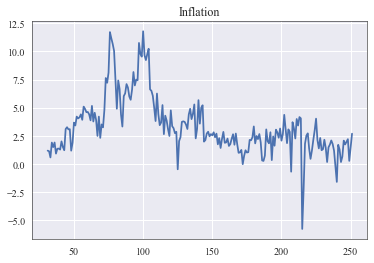

In [3]:
df_quarterly.INFL[31:].plot(title = 'Inflation');

In [4]:
import statsmodels.api as sm

acorr = sm.tsa.acf(df_quarterly.INFL.diff()[31:], nlags = 4)
acorr

array([ 1.        , -0.2459869 , -0.20364885,  0.13652049, -0.08508292])

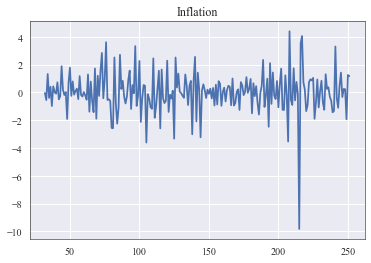

In [5]:
df_quarterly.INFL[31:].diff().plot(title = 'Inflation');

Autocorrelatoin are negative for first lag

In [6]:
df_quarterly['INFL_DIFF'] = df_quarterly.INFL.diff()

df_quarterly['INFL_DIFF_1'] = df_quarterly.INFL_DIFF.shift(1)

df_quarterly.dropna(inplace = True)

X = sm.add_constant(df_quarterly.INFL_DIFF_1)
Y = df_quarterly.INFL_DIFF

mod = sm.OLS(Y, X)
res = mod.fit(cov_type = "HC0", use_t = True)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              INFL_DIFF   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     14.83
Date:                Mon, 20 Mar 2023   Prob (F-statistic):           0.000152
Time:                        11:13:40   Log-Likelihood:                -408.79
No. Observations:                 232   AIC:                             821.6
Df Residuals:                     230   BIC:                             828.5
Df Model:                           1                                         
Covariance Type:                  HC0                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0013      0.093      0.014      

Yes, knowing change in inflation over current quarter helps in predicting change in inflation over next quarter

In [7]:

df_quarterly['INFL_DIFF_2'] = df_quarterly.INFL_DIFF.shift(2)
df_quarterly.dropna(inplace = True)

X = sm.add_constant(df_quarterly[['INFL_DIFF_1', 'INFL_DIFF_2']])
Y = df_quarterly.INFL_DIFF

mod = sm.OLS(Y, X)
result = mod.fit(cov_type = "HC0", use_t = True)
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:              INFL_DIFF   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.128
Method:                 Least Squares   F-statistic:                     14.68
Date:                Mon, 20 Mar 2023   Prob (F-statistic):           1.01e-06
Time:                        11:13:47   Log-Likelihood:                -395.96
No. Observations:                 230   AIC:                             797.9
Df Residuals:                     227   BIC:                             808.2
Df Model:                           2                                         
Covariance Type:                  HC0                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0016      0.089      0.018      

BIC is lower for AR(2), hence AR(2) is better

In [8]:

def create_lags(df_quarterly, lags):

    for lag in range(0, lags+1):

        df_quarterly[f'INFL_DIFF_{lag}'] = df_quarterly.INFL_DIFF.shift(lag)

    return df_quarterly.dropna()

df_quarterly = create_lags(df_quarterly, lags = 8)

In [9]:
def generate_ar_model(df_quarterly, lags):

    X = sm.add_constant(df_quarterly[[f'INFL_DIFF_{lag}' for lag in range(1, lags + 1)]])
    Y = df_quarterly.INFL_DIFF

    mod = sm.OLS(Y, X)
    res = mod.fit(cov_type = "HC0", use_t = True)

    return res.bic

In [10]:
bics = [(generate_ar_model(df_quarterly, lags = lag), lag) for lag in range(1, 9)]
bics

[(798.2571998193017, 1),
 (784.9981640348682, 2),
 (790.3952976226798, 3),
 (792.9169854652268, 4),
 (794.9934861726078, 5),
 (798.417566803009, 6),
 (803.7561736153941, 7),
 (808.8547603190331, 8)]

BIC is lowest at ar(2)

In [12]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:              INFL_DIFF   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.128
Method:                 Least Squares   F-statistic:                     14.68
Date:                Mon, 20 Mar 2023   Prob (F-statistic):           1.01e-06
Time:                        11:14:15   Log-Likelihood:                -395.96
No. Observations:                 230   AIC:                             797.9
Df Residuals:                     227   BIC:                             808.2
Df Model:                           2                                         
Covariance Type:                  HC0                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0016      0.089      0.018      

In [36]:
result.params.to_numpy() @ [1, df_quarterly.INFL_DIFF.iloc[-1], df_quarterly.INFL_DIFF_1.iloc[-1]]

-0.724391405258025

In [38]:
df_quarterly.INFL_DIFF.iloc[-1] + result.params.to_numpy() @ [1, df_quarterly.INFL_DIFF.iloc[-1], df_quarterly.INFL_DIFF_1.iloc[-1]]

0.4456221996020734

In [39]:
from statsmodels.tsa.stattools import adfuller

adfuller(df_quarterly.INFL, maxlag = 2)

(-2.7435044669106405,
 0.06680786347870574,
 2,
 219,
 {'1%': -3.460567372610299,
  '5%': -2.874829809033386,
  '10%': -2.573853225954421},
 761.8298408881388)